╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 11. CNN Architectures**
# Section 7. CIFAR-10을 이용한 ResNet 학습하기

### _Objective_

1. CIFAR-10 데이터셋을 바탕으로, ResNet 학습시켜 보도록 하겠습니다. <br>
2. ResNet 논문과 같이 유사한 결과가 나타나는 지 확인해보도록 하겠습니다. <br>
  
╚═════════════════════════════════════════╝

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
import shutil

!pip install tensorboardcolab
import tensorboardcolab

/Users/ksj/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


## Graph Visualization

In [2]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### 예제 데이터셋) CIFAR-10

* ResNet에서는 `CIFAR-10` 데이터셋을 이용해 학습하고, 성능 평가에 대한 결과를 내놓았습니다. <br> 논문과 비슷하게 나올 수 있도록 모델을 학습시켜 보도록 하겠습니다.

----

In [3]:
class Dataset:
    # 데이터셋을 배치 단위로 처리할 수 있도록 도와주는 Class
    def __init__(self, images, labels):
        self.images = images.copy()
        self.labels = labels.copy()
        self.labels = self.labels.ravel() # (None,1) -> (None,)
        self.counter = 0
        
    def __len__(self):
        # 데이터의 갯수를 반환
        # e.g) len(dataset)
        return len(self.images)

    def next_batch(self, batch_size=32):
        if self.counter + batch_size > len(self.images):
            # counter가 데이터셋의 갯수보다 초과한 경우,
            # 데이터셋을 섞어줌
            self.shuffle()
            self.counter = 0
        batch_images = self.images[self.counter:self.counter+batch_size]
        batch_labels = self.labels[self.counter:self.counter+batch_size]
        self.counter+=batch_size
        return batch_images.copy(), batch_labels.copy()
    
    def shuffle(self):
        # 데이터 셋을 섞어주는 함수
        indices = np.arange(len(self.images))
        np.random.shuffle(indices)        
        self.images = self.images[indices]
        self.labels = self.labels[indices]

In [4]:
from tensorflow.keras.datasets.cifar10 import load_data
(train_x, train_y), (test_x, test_y) = load_data()

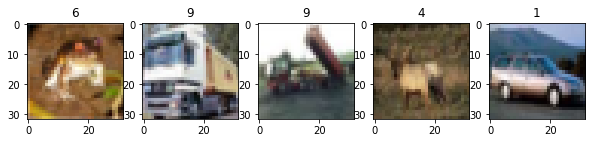

In [5]:
# 이미지 시각화하기
train_set = Dataset(train_x,train_y)

num_sample = 5

sample_x, sample_y = train_set.next_batch(num_sample)

fig = plt.figure(figsize=(10,3))
axes = fig.subplots(1,num_sample)

for ax, image, label in zip(axes, sample_x, sample_y):
    ax.set_title(label)
    ax.imshow(image)
plt.show()

<br>

# \[ 1. ResNet 구성하기 \]
---
---

> *ResNet 팀은 깊이에 따른 성능 변화를 추적하기 위해, CIFAR 데이터셋을 이용해 학습하였습니다.*<br>
> *ResNet 팀이 진행했던 CIFAR-10 결과를 재현해보도록 하겠습니다.*<br>

여기서 보면 CIFAR 데이터셋을 처리하기 위해 진행했던 여러 수정사항들을 확인해 볼 수 있습니다.

1. 첫번째 레이어를 3x3 Convolution Layer로 변경하였습니다.
2. 총 2번의 Pooling을 거쳐서 32x32 -> 16x16 -> 8x8로 Feature map의 크기가 줄어듭니다.
3. 총 Layer의 갯수가 6n+2일 때, 각 Layer의 필터 갯수는 위의 규칙을 따릅니다.

----

![Imgur](https://i.imgur.com/wg5Or2h.png)

위의 규칙에 따라 Inference Network 내 Layer의 수를 따지면 아래와 같습니다.

#### 각 구간 별 Layer의 수 

|Output map size | 32x32 | 16x16 | 8x8 | 출력층 |
|---|---|---|---|---|
|resnet-20 | 7 | 6 | 6 | 1 |
|resnet-32 | 11 | 10 | 10 | 1 |
|resnet-44 | 15 | 14 | 14 | 1 |
|resnet-56 | 19 | 18 | 18 | 1 |
|resnet-110 | 37 | 36 | 36 | 1 |
|resnet-1202 | 401 | 400 | 400 | 1 |

이번 시간에서는 resnet-20을 구성하여 Test error가 8.75% 수준으로 나오는지 확인해 보도록 하겠습니다.

<br>

## 1. Inference Network 구성하기
---

|Output map size | 32x32 | 16x16 | 8x8 | 출력층 |
|---|---|---|---|---|
|resnet-20 | 7 | 6 | 6 | 1 |

이 규칙에 따라 구성해보도록 하겠습니다. 

In [6]:
def residual_block(input_layer, is_train, filters, strides=(1,1), block_name="residual_block"):
    he_init = tf.initializers.he_normal()    
    with tf.variable_scope(block_name):
        if input_layer.shape.as_list()[-1] != filters:
            # input_layer의 필터 갯수와 filters가 다르면, projection layer을 거침
            projection = tf.layers.Conv2D(filters, (1,1), strides=strides)(input_layer)
        else:
            # 동일하면 바로 이어줌
            projection = input_layer
        
        conv = tf.layers.Conv2D(filters, (3,3), strides, padding='SAME',
                                kernel_initializer=he_init)(input_layer)
        bn = tf.layers.BatchNormalization()(conv, training=is_train)
        act = tf.nn.relu(bn)
        conv = tf.layers.Conv2D(filters, (3,3), padding='SAME',
                                kernel_initializer=he_init)(act)
        bn = tf.layers.BatchNormalization()(conv, training=is_train)
        added = tf.add(projection, bn)
        out = tf.nn.relu(added)       

    return out        

In [9]:
input_shape = (None,32,32,3)
num_classes = 10

graph = tf.Graph()
with graph.as_default():
    images = tf.placeholder(tf.float32, input_shape, name='images')
    labels = tf.placeholder(tf.int32, (None,), name='labels')
    is_train = tf.placeholder_with_default(False, (), name='is_train')
    
    with tf.variable_scope("preprocess"):
        image_mean = tf.constant([123.68, 116.779, 103.939], tf.float32)
        x = images - image_mean
    
    he_init = tf.initializers.he_normal()
    xavier_init = tf.initializers.glorot_normal()
    
    for i in range(1,5):
        if i == 1:
            conv = tf.layers.Conv2D(16,(3,3),
                                    kernel_initializer=he_init,
                                    padding='SAME',name='32x32_1')(x)
        else:
            conv = residual_block(conv, is_train, 16,
                                  block_name='32x32_{}'.format(i))

    for i in range(1,4):
        if i == 1:
            conv = residual_block(conv, is_train, 32, strides=(2,2),
                                  block_name='16x16_{}'.format(i))            
        else:
            conv = residual_block(conv, is_train, 32,
                                  block_name='16x16_{}'.format(i))
            
    for i in range(1,4):
        if i == 1:
            conv = residual_block(conv, is_train, 64, strides=(2,2),
                                  block_name='8x8_{}'.format(i))            
        else:
            conv = residual_block(conv, is_train, 64,
                                  block_name='8x8_{}'.format(i))
            
    with tf.variable_scope('global_average_pooling'):
        gap = tf.reduce_mean(conv, axis=(1,2))    
    logits = tf.layers.Dense(num_classes,
                             kernel_initializer=xavier_init,
                             name='logits')(gap)
    y_pred = tf.nn.softmax(logits,name='prediction')            

In [10]:
show_graph(graph)

<br>

## 2. 학습에 관련된 부분들 구성하기
---

* 논문과 동일하게 구현하도록 하겠습니다.<br>

###  (1) Loss Function 구성하기

![Imgur](https://i.imgur.com/RkeK3yI.png)

논문과 동일하게 L2-Loss을 포함하겠습니다.

In [11]:
weight_decay = 1e-4 #
with graph.as_default():
    with tf.variable_scope("losses"):
        sce = tf.losses.sparse_softmax_cross_entropy(labels, logits)    
        
        weights = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                               scope='^.*/kernel.*$')
        l2_loss = tf.add_n([tf.nn.l2_loss(weight) 
                            for weight in weights])
        
        loss = sce + weight_decay * l2_loss
    loss = tf.identity(loss, name='loss')  

Instructions for updating:
Use tf.cast instead.


### (2) Optimizer 구성하기

논문과 동일하게 Momentum Optimizer을 이용하도록 하겠습니다.

In [12]:
momentum = 0.9
with graph.as_default():
    lr = tf.placeholder_with_default(1e-1, (), name='learning_rate')    
    global_step = tf.train.get_or_create_global_step()
    with tf.variable_scope("optimizer"):
        update_ops = graph.get_collection(tf.GraphKeys.UPDATE_OPS)        
        with tf.control_dependencies(update_ops):
            train_op = (tf.train
                        .MomentumOptimizer(lr,momentum=momentum,use_nesterov=True)
                        .minimize(loss,global_step=global_step))

Instructions for updating:
Use tf.cast instead.


### (3) Metric 구성하기

논문에서는 Error를 Metric으로 이용했습니다. Error는 아래와 같이 구합니다.<br>
$$error = 100\% - accuracy$$

In [13]:
with graph.as_default():
    with tf.variable_scope('metrics'):
        acc = tf.cast(tf.nn.in_top_k(logits, labels, k=1),tf.float32)
        acc, acc_op = tf.metrics.mean(acc)
        error = 100. * (1. - acc)
        
        metric_loss, loss_op = tf.metrics.mean(loss)
    
    # Total과 Count를 reset하는 연산자
    metric_init_op = tf.group([var.initializer for var in
                               graph.get_collection(tf.GraphKeys.METRIC_VARIABLES)],
                              name='metric_init_op')
    # Total과 Count를 갱신하는 연산자
    metric_update_op = tf.group([acc_op, loss_op], 
                                name='metric_update_op')

    error = tf.identity(error, name='error')
    metric_loss = tf.identity(metric_loss, name='metric_loss')            
    
    tf.summary.scalar('error_rate', error)
    tf.summary.scalar('losses', metric_loss)    
    merged = tf.summary.merge_all()                     

<br>

## 2. 모델 학습시키기
----



### (1) 데이터 셋 구성하기


![Imgur](https://i.imgur.com/3WWXRsb.png)

논문에 명시된 것과 같이 Validation Dataset과 Train Dataset을 나누도록 하겠습니다.

In [14]:
from tensorflow.keras.datasets.cifar10 import load_data
(train_x, train_y), (test_x, test_y) = load_data()

# train-validation dataset split
indices = np.arange(50000)
np.random.shuffle(indices)
valid_x, valid_y = train_x[indices[:5000]], train_y[indices[:5000]]
train_x, train_y = train_x[indices[5000:]], train_y[indices[5000:]]

train_y = train_y.reshape((-1,)) # (None, 1) -> (None, )
valid_y = valid_y.reshape((-1,))
test_y = test_y.reshape((-1,)) 

train_set = Dataset(train_x,train_y)
valid_set = Dataset(valid_x,valid_y)
test_set = Dataset(test_x,test_y)

### (2) Data Augmentation 적용하기

![Imgur](https://i.imgur.com/jhLkXS3.png)

논문에 언급된 대로 구현하겠습니다.<br>

In [15]:
def random_crop_and_pad(images,pad=4):
    """
    pad 크기만큼 무작위로 위아래, 좌우로 움직이는 메소드
    """
    _, h, w, _ = images.shape
    pad_images = np.pad(images,[(0,0),(pad,pad),(pad,pad),(0,0)],
                        mode='constant')
    
    crops = []
    for idx, image in enumerate(pad_images):
        start_y = np.random.randint(0,pad)
        start_x = np.random.randint(0,pad)
        cropped = image[start_y:start_y+h,
                        start_x:start_x+w]
        crops.append(cropped)
    return np.stack(crops)

def random_flip_left_right(images):
    """
    무작위로 이미지를 좌우로 뒤집어 주는 메소드    
    """
    for idx, image in enumerate(images):
        if np.random.random() > 0.5:
            images[idx] = image[:,::-1]
    return images

In [16]:
def augment_images(images):
    """
    평행이동 -> 뒤집기을 거쳐 데이터에 노이즈를 주는 메소드
    """
    images = random_crop_and_pad(images, pad=4)
    images = random_flip_left_right(images)
    return images

### (3) 학습과정을 기록할 Tensorboard 구성하기

In [17]:
# LOG PATH Setting
LOG_DIR = "./log"
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

tbc = tensorboardcolab.TensorBoardColab(graph_path=LOG_DIR)

train_writer = tf.summary.FileWriter(LOG_DIR+"/train", graph)
valid_writer = tf.summary.FileWriter(LOG_DIR+"/validation")

### (4) 세션 초기화하기

In [18]:
# 변수 초기화 및 Operation 가져오기
sess = tf.Session(graph=graph)
with graph.as_default():
    sess.run([tf.global_variables_initializer(),
              tf.local_variables_initializer()])

### (5) 모델 학습하기 

논문과 다르게, 초기에 Learning_rate를 0.1로 줄 경우, Gradient Exploding 문제가 발생합니다.
그래서 여기에서는 처음부터 0.001로 학습한 후, 중간에 다시 0.005로 올려서 학습을 가속한 후 줄이는 방식으로 진행하겠습니다. 
줄어든 Learning rate을 보상하기 위해, 조금 더 길게 학습하도록 하겠습니다.

In [ ]:
num_steps = 100000
num_batch = 256

lr_value = 1e-3 # 1e-1로 돌릴 경우, Gradient가 너무 커서, 학습이 되지 않습니다.
for step in tqdm(range(num_steps)):
    if step <= 5000:
        lr_value = 1e-3
    elif step <= 30000:
        lr_value = 5e-3
    else:
        lr_value = 1e-3       
    
    # Training Model one step
    batch_x, batch_y = train_set.next_batch(num_batch)
    batch_x = augment_images(batch_x)
    sess.run(train_op,feed_dict={
        images: batch_x, labels: batch_y,
        is_train:True, lr: lr_value})
    
    if step % 1000 == 0:
        # Summarize training process
        sess.run(metric_init_op)
        for step in range(0,len(train_set)//5000):
            # 5000개씩 나누어서 metric을 계산합니다.
            batch_x = train_x[step*5000:(step+1)*5000]
            batch_y = train_y[step*5000:(step+1)*5000]
            sess.run(metric_update_op,feed_dict={images:batch_x,
                                                 labels:batch_y})
        summary = sess.run(merged)
        train_writer.add_summary(summary, global_step.eval(sess))
        train_writer.flush()

        sess.run(metric_init_op)
        for step in range(len(valid_set)//5000):
            batch_x = valid_x[step*5000:(step+1)*5000]
            batch_y = valid_y[step*5000:(step+1)*5000]
            sess.run(metric_update_op,feed_dict={images:batch_x,
                                                 labels:batch_y})
        summary = sess.run(merged)
        valid_writer.add_summary(summary, global_step.eval(sess))        
        valid_writer.flush()

### (6) 모델 평가하기

In [ ]:
sess.run(metric_init_op)
for step in range(len(test_set)//1000):
    batch_x = test_x[step*1000:(step+1)*1000]
    batch_y = test_y[step*1000:(step+1)*1000]
    sess.run(metric_update_op,feed_dict={images:batch_x,
                                         labels:batch_y})

final_error_rate = sess.run(error)
print("최종 TEST ERROR : {:2.3f}%".format(final_error_rate))

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/14

---